## 比赛和数据概述：

在这场比赛中，我们面临的挑战是，如何预测俄罗斯软件公司[1c公司](http://1c.ru/eng/title.htm)下个月每种产品和商店的总销售额。

> 1C公司是干什么的？
>
> 1C公司的 Enterprise 8 程序系统旨在实现日常企业活动的自动化：经济和管理活动的各种业务，例如管理会计、业务会计、HR管理、CRM、SRM
MRP、MRP等。

**数据**：我们现在有每种商品组合的日销售数据，我们的任务是预测每月的销售量。

In [7]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# 可视化
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

导入数据：

In [8]:
# settings
import warnings
warnings.filterwarnings("ignore")

# 导入销售数据
sales=pd.read_csv("../datasets/Predict Future Sales/sales_train.csv")

item_cat=pd.read_csv("../datasets/Predict Future Sales/item_categories.csv")
item=pd.read_csv("../datasets/Predict Future Sales/items.csv")
sub=pd.read_csv("../datasets/Predict Future Sales/sample_submission.csv")
shops=pd.read_csv("../datasets/Predict Future Sales/shops.csv")
test=pd.read_csv("../datasets/Predict Future Sales/test.csv")

In [9]:
# 正确处理时间列
sales['date'] = sales['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

# 检查
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [12]:
sales.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
6,2013-01-02,0,25,2565,549.00,1.0
7,2013-01-04,0,25,2572,239.00,1.0
8,2013-01-11,0,25,2572,299.00,1.0
9,2013-01-03,0,25,2573,299.00,3.0


In [10]:
# Aggregate to monthly level the required metrics

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [11]:
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

   item_category_id  item_name  item_id
0                40       5035     5035
1                55       2365     2365
2                37       1780     1780
3                31       1125     1125
4                58        790      790
5                30        756      756
6                72        666      666
7                19        628      628
8                61        598      598
9                23        501      501


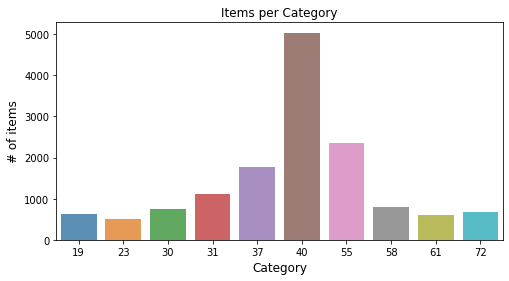

In [14]:
# 每个类型的商品数量
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id',ascending=False)
x = x.iloc[0:10].reset_index()
print(x)

# plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

当然，我们可以在此数据集中挖掘更多内容。但是，首先我们还是来深入了解“时间序列”部分。

### Single series:

该目标要求我们以 store-item 组合来预测下个月的销售额。

每个 store-item 随着时间的销售情况本身就是一个时间序列。在深入研究所有组合之前，首先让我们了解如何预测单个序列。

首先，我们选择预测整个公司每月的总销售额。让我们计算每月的总销售额并绘制该数据。

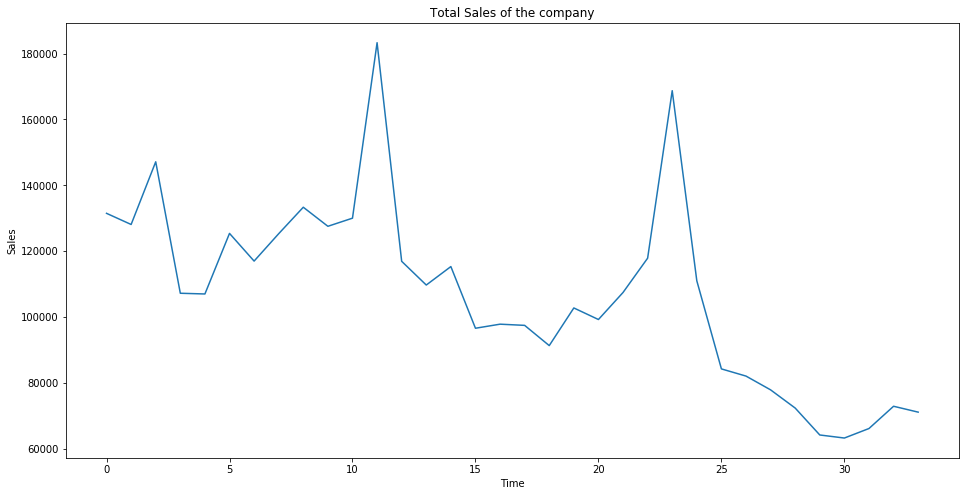

In [15]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

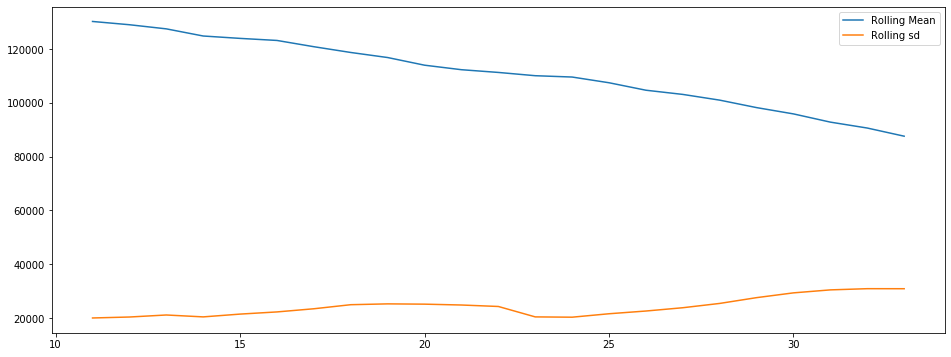

In [16]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

#### 快速观察

存在明显的“季节性”（例如：一年中某个时间的销售高峰）和“趋势”下降。

让我们通过快速分解为趋势，季节性和残差进行检查。

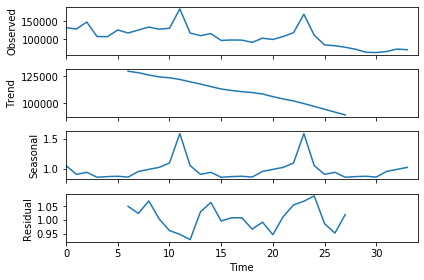

In [20]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

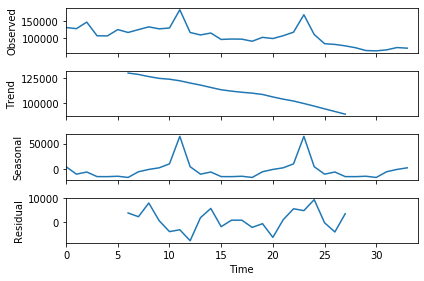

In [21]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

### Stationarity - 稳态

![img](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)

稳态指的是序列的时间不变性。即时间序列中的两个点之间的关系仅仅取决于彼此之间的距离，而不是方向（向前、向后。）

当时间序列固定时，更容易建模，这里我们假定时间序列是稳态的。

有多种方法可以检测时间序列是不是稳态的：

- ADF( Augmented Dicky Fuller Test)
- KPSS
- PP (Phillips-Perron test)

这里我们使用 ADF 这种常用方法。

In [22]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64
